# Introductory machine learning experiment with Scikit-Learn

## Google colab setup

This cell downloads and installs the notebook's requirements in the Google Colab runtime.
You should comment or delete it if you are not running the notebook on Google Colab.

In [ ]:
# Disable cell output
%%capture

# Download the repository from github
!git clone https://github.com/5TuX/ml-radiomics-classification.git

# Set working directory
%cd ml-radiomics-classification

# Install dependencies with uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
import os

os.environ["PATH"] = f"/root/.cargo/bin:{os.environ['PATH']}"
!uv sync

## Introduction 

### The goal

The purpose of this tutorial is to showcase a basic machine learning training pipeline that you can apply on your own tabular datasets. 

Let's imagine we have a reasonably sized tabular dataset (e.g. a CSV file) where each line is a sample and each column is a feature. We want to train a model to predict one of these columns (the target feature) using the other columns (the input features).

### Training machine learning models

There are a lot of general approaches to machine learning:
- Supervised learning trains models on labelled data (most common)
- Unsupervised learning searches patterns in unlabelled data
- Self-supervised learning uses labels automatically generated from the data itself (e.g., contrastive learning)
- Reinforcement learning learns by interacting in an environment to maximize a reward
- Many more learning paradigms are listed on wikipedia: https://en.wikipedia.org/wiki/Machine_learning

In this notebook, we'll focus on a supervised learning classification task, which consists in predicting a class label from a set of input variables. Another common supervised machine learning task is regression, which tries to predict a continuous value. It won't be addressed here.

The Python scikit-learn library provides lots of tools to experiment with machine learning methods on our dataset. In this tutorial, we will showcase some of these tools that will help us to:
- Split the dataset in training and test subset (testing is crucial to avoid overfitting)
- Create a preprocessing pipeline for the data (numerical variable normalization, categorical variable one-hot encoding)
- Leverage cross-validation to quickly compare a bunch of different models
- Do the final training and evaluation of one selected model

### Spending time with the data

Playing around with AI models is only 10% of the job. The other 90% is spending time with the data to understand it and make sure what we do has a meaning. This involves loading the dataset, visualizing and exploring the data, looking at feature distributions and correlations, selecting input and target features, handling missing values, possibly creating new features... In this tutorial, we'll hide most of this part to focus on scikit-learn tools, but keep in mind that in a real-world scenario your dataset will never be ready to use for training out-of-the box.

A widely used Python library for handling tabular data is Pandas. In this tutorial however, we prefered to briefly showcase a more recent library named [Polars](https://github.com/pola-rs/polars). Notably, Polars prefers to use [Altair](https://github.com/vega/altair) over Matplotlib for interactive plotting and visualization. Polars provides tools to convert to Pandas format, but scikit-learn is compatible with both libraries anyway.

### References

- This notebook is heavily inspired by Aurelien Geron's [End-to-end machine learning project](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb) notebook from his book [Hand-on machine learning with scikit-learn and Pytorch](https://www.oreilly.com/library/view/hands-on-machine-learning/9798341607972/). In this tutorial we're looking at a classification task, but his example focuses on regression. Feel free to check it out if you are interested.
- Andrej Karpathy provides a nifty [Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) which gives useful guidelines for any machine learning project and points at common mistakes to avoid.
- The CNRS has a freely accessible program called [FIDLE](https://fidle.cnrs.fr), yearly revisited, wich provides a nice entry point for anyone curious about artifical intelligence.

## The Dataset

In this notebook, we are looking at a version of the [BraTS-2020-Openradiomics](https://openradiomics.org/?page_id=1087) dataset (see [publication](https://doi.org/10.1186/s12880-025-01855-2)). 

It contains information of 369 adult patients with brain tumors. Each line contains around 1500 [radiomic](https://en.wikipedia.org/wiki/Radiomics) features computed from tumor segmentations of the patient's MRI scans, as well as two target variables: 
- The category of brain tumor:
    - "LGG" for low-grade glioma (less aggressive tumor)
    - "HGG" for high-grade glioma (more aggressive tumor)
- Survival information (in days, provided for 236 patients)

<figure style="max-width: 600px; margin: auto; text-align: left;">
    <img src="https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12880-025-01855-2/MediaObjects/12880_2025_1855_Fig1_HTML.png">
    <figcaption>An example BraTS 2020 image (the FLAIR sequence) and its corresponding segmentation mask. The orange area is AT (active tumor), the green area is ED (peritumoral edematous/invaded tissue), and the gray parts are NETnNCR (Union of necrotic and non-enhancing tumor)</figcaption>
</figure>

We will ignore the survival information entirely and try to predict the class of the tumor (LGG or HGG) with a binary classifier. We'll drop most of the radiomic feature and keep only the original ones (107 input features).

## Python imports and settings

In [2]:
# Python imports
import re
from itertools import groupby

# Data handling imports
import polars as pl

# Scikit-learn utility imports
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

# Scikit-learn model imports
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Other imports
from tabulate import tabulate  # for pretty-printing tables
import altair as alt  # for plotting

In [3]:
settings = {
    "dataset-path": "data/Radiomics_binWidth-15_ZScore_NETnNCR_T1CE.csv",
}

## Preparing the data

Here we decide what columns to keep, how to handle missing values, and we put a test set aside (20% of the data) for evaluating our final model. All further data pre-processing and model training will be done on the rest of the data without ever looking at the test set.

### Loading the data

Use Polars (you can also use Pandas) to load the dataset from the CSV file:

In [4]:
df = pl.read_csv(settings["dataset-path"])
print("Dataset shape:", df.shape)

Dataset shape: (369, 1720)


### First look at the raw data

Look at a few examples to get an idea of the data structure:

In [5]:
df.head()

Patient_ID,Group,Group_label,binWidth,Normalization,Age,Survival_days,Extent_of_Resection,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,…,wavelet-LLL_glrlm_GrayLevelNonUniformity,wavelet-LLL_glrlm_GrayLevelNonUniformityNormalized,wavelet-LLL_glrlm_GrayLevelVariance,wavelet-LLL_glrlm_HighGrayLevelRunEmphasis,wavelet-LLL_glrlm_LongRunEmphasis,wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis,wavelet-LLL_glrlm_LongRunLowGrayLevelEmphasis,wavelet-LLL_glrlm_LowGrayLevelRunEmphasis,wavelet-LLL_glrlm_RunEntropy,wavelet-LLL_glrlm_RunLengthNonUniformity,wavelet-LLL_glrlm_RunLengthNonUniformityNormalized,wavelet-LLL_glrlm_RunPercentage,wavelet-LLL_glrlm_RunVariance,wavelet-LLL_glrlm_ShortRunEmphasis,wavelet-LLL_glrlm_ShortRunHighGrayLevelEmphasis,wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-LLL_glszm_GrayLevelNonUniformity,wavelet-LLL_glszm_GrayLevelNonUniformityNormalized,wavelet-LLL_glszm_GrayLevelVariance,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis,wavelet-LLL_glszm_LargeAreaEmphasis,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
str,str,i64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BraTS20_Training_001""","""HGG""",1,"""binWidth-15""","""ZScore""",60.463,"""289""","""GTR""","""NETnNCR""","""T1CE""","""v3.0.1""","""1.20.3""","""2.1.1""","""1.1.1""","""3.9.7""","""{'minimumROIDimensions': 2, 'm…","""{'Original': {}, 'Exponential'…","""fcf31c6f56b4067eb28299303a0674…","""3D""","""(1.0, 1.0, 1.0)""","""(240, 240, 155)""",-6.4336e-16,-0.404772,11.492377,"""f3599f6c7ce9538e47d18beaef7292…","""(1.0, 1.0, 1.0)""","""(240, 240, 155)""","""(70, 102, 41, 50, 56, 37)""",15443.0,34.0,"""(89.23389237842387, 122.326749…","""(89.23389237842387, 122.326749…",0.731829,0.41979,21.139285,50.356792,50.358713,…,2837.692308,1.0,0.0,1.0,56.108317,56.108317,56.108317,1.0,3.683174,314.441224,0.108017,0.183753,23.691856,0.28482,0.28482,0.28482,34.0,1.0,0.0,1.0,6.3840e6,6.3840e6,6.3840e6,1.0,5.470588,0.1609,0.379267,0.379267,0.379267,3.133984,0.002202,6.1777e6,0.0,1e6,0.0,0.0,0.0
"""BraTS20_Training_002""","""HGG""",1,"""binWidth-15""","""ZScore""",52.263,"""616""","""GTR""","""NETnNCR""","""T1CE""","""v3.0.1""","""1.20.3""","""2.1.1""","""1.1.1""","""3.9.7""","""{'minimumROIDimensions': 2, 'm…","""{'Original': {}, 'Exponential'…","""58a926796869be2fcbfafa87f1e2d3…","""3D""","""(1.0, 1.0, 1.0)""","""(240, 

Look at basic statistics: 
- number of defined and undefined values in each column
- means, standard deviations etc.

In [6]:
df.describe()

statistic,Patient_ID,Group,Group_label,binWidth,Normalization,Age,Survival_days,Extent_of_Resection,Subregion,Sequence,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,…,wavelet-LLL_glrlm_GrayLevelNonUniformity,wavelet-LLL_glrlm_GrayLevelNonUniformityNormalized,wavelet-LLL_glrlm_GrayLevelVariance,wavelet-LLL_glrlm_HighGrayLevelRunEmphasis,wavelet-LLL_glrlm_LongRunEmphasis,wavelet-LLL_glrlm_LongRunHighGrayLevelEmphasis,wavelet-LLL_glrlm_LongRunLowGrayLevelEmphasis,wavelet-LLL_glrlm_LowGrayLevelRunEmphasis,wavelet-LLL_glrlm_RunEntropy,wavelet-LLL_glrlm_RunLengthNonUniformity,wavelet-LLL_glrlm_RunLengthNonUniformityNormalized,wavelet-LLL_glrlm_RunPercentage,wavelet-LLL_glrlm_RunVariance,wavelet-LLL_glrlm_ShortRunEmphasis,wavelet-LLL_glrlm_ShortRunHighGrayLevelEmphasis,wavelet-LLL_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-LLL_glszm_GrayLevelNonUniformity,wavelet-LLL_glszm_GrayLevelNonUniformityNormalized,wavelet-LLL_glszm_GrayLevelVariance,wavelet-LLL_glszm_HighGrayLevelZoneEmphasis,wavelet-LLL_glszm_LargeAreaEmphasis,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
str,str,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,str,str,str,str,f64,f64,str,str,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""369""","""369""",369.0,"""369""","""369""",236.0,"""236""","""129""","""369""","""369""","""368""","""368""","""368""","""368""","""368""","""368""","""368""","""368""","""368""","""368""","""368""",368.0,368.0,368.0,"""368""","""368""","""368""","""368""",368.0,368.0,"""368""","""368""",368.0,368.0,368.0,368.0,…,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",133.0,"""133""","""240""","""0""","""0""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""",1.0,1.0,1.0,"""1""","""1""","""1""","""1""",1.0,1.0,"""1""","""1""",1.0,1.0,1.0,1.0,…,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""mean""",null,null,0.794038,null,null,61.223203,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,-1.3152e-17,-0.419098,10.345853,null,null,null,null,22179.336957,33.103261,null,null,0.723042,0.555079,24.485618,45.730192,…,2963.677357,0.994174,0.002913,1.3

### Choosing columns to keep

#### Understanding the structure of the columns

There is a huge number of columns. Let's quickly explore the structure of column names:

In [7]:
print(f"{len(df.columns)} columns in total.\n")


def key(colname):
    return colname.split("_")[0]


for column_group, columns in groupby(df.columns, key):
    print(column_group)
    columns = list(columns)
    if len(columns) == 1:
        print(f"\t-> {columns}")
        continue
    columns = [colname[len(column_group) + 1 :] for colname in columns]
    for column_subgroup, subcolumns in groupby(columns, key):
        maxlen, suffix = 3, ""
        subcolumns = [colname[len(column_subgroup) + 1 :] for colname in subcolumns]
        if (lensubcols := len(subcolumns)) > maxlen:
            subcolumns = subcolumns[:maxlen]
            suffix = f"... ({lensubcols} total)"
        print(f"\t{column_subgroup} -> {subcolumns} {suffix}")

1720 columns in total.

Patient
	-> ['Patient_ID']
Group
	 -> [''] 
	label -> [''] 
binWidth
	-> ['binWidth']
Normalization
	-> ['Normalization']
Age
	-> ['Age']
Survival
	-> ['Survival_days']
Extent
	-> ['Extent_of_Resection']
Subregion
	-> ['Subregion']
Sequence
	-> ['Sequence']
diagnostics
	Versions -> ['PyRadiomics', 'Numpy', 'SimpleITK'] ... (5 total)
	Configuration -> ['Settings', 'EnabledImageTypes'] 
	Image-original -> ['Hash', 'Dimensionality', 'Spacing'] ... (7 total)
	Mask-original -> ['Hash', 'Spacing', 'Size'] ... (8 total)
original
	shape -> ['Elongation', 'Flatness', 'LeastAxisLength'] ... (14 total)
	firstorder -> ['10Percentile', '90Percentile', 'Energy'] ... (18 total)
	glcm -> ['Autocorrelation', 'ClusterProminence', 'ClusterShade'] ... (24 total)
	gldm -> ['DependenceEntropy', 'DependenceNonUniformity', 'DependenceNonUniformityNormalized'] ... (14 total)
	glrlm -> ['GrayLevelNonUniformity', 'GrayLevelNonUniformityNormalized', 'GrayLevelVariance'] ... (16 total)
	gls

#### Selecting wanted columns

In [8]:
# We can either specify columns to drop or to keep.
# In this case, there are 1720 columns, so it's easier to specify which ones to keep.

# Target variables: ignore Survival_days (too many missing values)
targets = ["Group"]

# Clinical inputs: ignore Age and Extent_of_Resection (too many missing values):
inputs_clinical = []

# Radiomic inputs: keep only basic radiomic features and ignore the rest:
inputs_radiomics = [col for col in df.columns if col.startswith("original_")]
df = df.select(targets + inputs_clinical + inputs_radiomics).rename(
    {col: col[9:] for col in inputs_radiomics}
)

# By doing this selection, we also dropped the following metadata columns:
# Patient_ID, Group_label, binWidth, Normalization, Subregion, Sequence
# As well as all diagnostics_... columns (give information about radiomic feature extraction process)

### Handling missing values

Handle missing values: in this case there is only one row with missing data (as shown by the `df.describe` output above).

Generally, there are different strategies to handle missing data:
- Dropping all rows with missing values (like we do here since there is only one)
- Dropping columns with missing values (after checking there is almost no data in them)
- Filling missing values, e.g. with the median (imputation)

In [9]:
df = df.drop_nulls()
print("Dataset shape after dropping nulls:", df.shape)

Dataset shape after dropping nulls: (368, 108)


### Looking at the prepared data

Look again at a few examples and basic statistics:

In [10]:
df.head()

Group,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,shape_Sphericity,shape_SurfaceArea,shape_SurfaceVolumeRatio,shape_VoxelVolume,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,firstorder_Minimum,firstorder_Range,firstorder_RobustMeanAbsoluteDeviation,firstorder_RootMeanSquared,firstorder_Skewness,firstorder_TotalEnergy,firstorder_Uniformity,firstorder_Variance,glcm_Autocorrelation,glcm_ClusterProminence,glcm_ClusterShade,glcm_ClusterTendency,…,glrlm_GrayLevelNonUniformity,glrlm_GrayLevelNonUniformityNormalized,glrlm_GrayLevelVariance,glrlm_HighGrayLevelRunEmphasis,glrlm_LongRunEmphasis,glrlm_LongRunHighGrayLevelEmphasis,glrlm_LongRunLowGrayLevelEmphasis,glrlm_LowGrayLevelRunEmphasis,glrlm_RunEntropy,glrlm_RunLengthNonUniformity,glrlm_RunLengthNonUniformityNormalized,glrlm_RunPercentage,glrlm_RunVariance,glrlm_ShortRunEmphasis,glrlm_ShortRunHighGrayLevelEmphasis,glrlm_ShortRunLowGrayLevelEmphasis,glszm_GrayLevelNonUniformity,glszm_GrayLevelNonUniformityNormalized,glszm_GrayLevelVariance,glszm_HighGrayLevelZoneEmphasis,glszm_LargeAreaEmphasis,glszm_LargeAreaHighGrayLevelEmphasis,glszm_LargeAreaLowGrayLevelEmphasis,glszm_LowGrayLevelZoneEmphasis,glszm_SizeZoneNonUniformity,glszm_SizeZoneNonUniformityNormalized,glszm_SmallAreaEmphasis,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""HGG""",0.731829,0.41979,21.139285,50.356792,50.358713,59.539903,50.990195,63.85922,15226.333333,36.852581,0.333812,8899.775397,0.584499,15443.0,0.891341,2.406696,43805.647206,0.000994,0.76735,3.905945,4.857057,0.476079,1.57019,1.471689,-0.037217,4.894274,0.322622,1.684222,0.845454,43805.647206,0.99987,0.371107,3.999682,0.000159,-0.000159,0.000159,…,2837.693033,0.999275,0.000362,3.998912,56.052892,224.210478,14.013495,0.250272,3.685716,315.192629,0.108203,0.183882,23.686554,0.285304,1.140127,0.071598,33.057143,0.94449,0.027755,3.914286,6.2008e6,2.4803e7,1.5502e6,0.271429,5.971429,0.170612,0.397002,1.502295,0.120679,3.231618,0.002266,6.0061e6,0.300826,0.831125,0.000156,9.2377e-9,0.90777
"""HGG""",0.805201,0.596898,17.919111,30.020387,34.132096,34.525353,31.144823,35.496479,9073.541667,24.172434,0.73062,2879.455924,0.317346,9160.0,0.511066,1.20927,7040.180407,-3.2034e-16,0.263257,10.595436,3.429786,0.233776,0.801736,0.711371,0.013167,3.416619,0.120232,0.876686,2.380337,7040.180407,1.0,0.125799,1.0,0.0,0.0,0.0,…,931.230769,1.0,0.0,1.0,148.738015,148.738015,148.738015,1.0,4.063811,65.188726,0.068125,0.101663,37.847387,0.148596,0.148596,0.148596,9.0,1.0,0.0,1.0,9.1449e6,9.1449e6,9.1449e6,1.0,1.0,0.111111,0.155282,0.155282,0.155282,3.169925,0.000983,8.1090e6,0.0,1e6,0.0,0.0,0.0
"""HGG""",0.768372,0.722447,11.550058,15.987407,18.681542,18.384776,18.681542,22.135944,684.083333,12.284284,0.406249,924.196735,1.351,733.0,1.441948,3.355092,4630.563368,-3.2034e-16,1.090258,2.45011,4.360985,0.592579,2.407835,2.420584,0.713811,3.647174,0.43292,2.513419,0.055125,4630.563368,1.0,0.519605,1.0,0.0,0.0,0.0,…,291.153846,1.0,0.0,1.0,10.77577,10.77577,10.77577,1.0,2.387787,77.714144,0.259495,0.397209,3.934461,0.500213,0.500213,0.500213,7.0,1.0,0.0,1.0,62367.571429,62367.571429,62367.571429,1.0,1.285714,0.183673,0.298127,0.298127,0.298127,2.521641,0.00955,51402.489796,0.0,1e6,

In [11]:
df.describe()

statistic,Group,shape_Elongation,shape_Flatness,shape_LeastAxisLength,shape_MajorAxisLength,shape_Maximum2DDiameterColumn,shape_Maximum2DDiameterRow,shape_Maximum2DDiameterSlice,shape_Maximum3DDiameter,shape_MeshVolume,shape_MinorAxisLength,shape_Sphericity,shape_SurfaceArea,shape_SurfaceVolumeRatio,shape_VoxelVolume,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,firstorder_Minimum,firstorder_Range,firstorder_RobustMeanAbsoluteDeviation,firstorder_RootMeanSquared,firstorder_Skewness,firstorder_TotalEnergy,firstorder_Uniformity,firstorder_Variance,glcm_Autocorrelation,glcm_ClusterProminence,glcm_ClusterShade,…,glrlm_GrayLevelNonUniformity,glrlm_GrayLevelNonUniformityNormalized,glrlm_GrayLevelVariance,glrlm_HighGrayLevelRunEmphasis,glrlm_LongRunEmphasis,glrlm_LongRunHighGrayLevelEmphasis,glrlm_LongRunLowGrayLevelEmphasis,glrlm_LowGrayLevelRunEmphasis,glrlm_RunEntropy,glrlm_RunLengthNonUniformity,glrlm_RunLengthNonUniformityNormalized,glrlm_RunPercentage,glrlm_RunVariance,glrlm_ShortRunEmphasis,glrlm_ShortRunHighGrayLevelEmphasis,glrlm_ShortRunLowGrayLevelEmphasis,glszm_GrayLevelNonUniformity,glszm_GrayLevelNonUniformityNormalized,glszm_GrayLevelVariance,glszm_HighGrayLevelZoneEmphasis,glszm_LargeAreaEmphasis,glszm_LargeAreaHighGrayLevelEmphasis,glszm_LargeAreaLowGrayLevelEmphasis,glszm_LowGrayLevelZoneEmphasis,glszm_SizeZoneNonUniformity,glszm_SizeZoneNonUniformityNormalized,glszm_SmallAreaEmphasis,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""368""",368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,…,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0,368.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,0.723042,0.555079,24.485618,45.730192,45.057,51.053797,49.333276,56.808197,21862.7851,32.004908,0.376242,9237.61258,0.923609,22179.336957,1.374584,2.522678,74696.113733,0.007873,0.626598,3.996735,4.162478,0.36554,1.920441,1.882498,0.571002,3.591476,0.261605,1.985013,0.372539,74696.113733,0.996985,0.23679,1.530893,0.006383,-0.003187,…,2971.81061,0.994031,0.002985,1.526069,100.816023,186.329359,79.43769,0.868483,3.329075,428.802215,0.183117,0.2571,38.653377,0.369848,0.53148,0.32944,34.180723,0.959979,0.02001,1.353266,3.3695e8,5.0550e8,2.9481e8,0.911684,9.541138,0.32483,0.43707,0.604474,0.395219,2.36478,0.008932,1.1143e8,14.646119,826087.014728,0.0014,0.000218,0.055786
"""std""",null,0.155188,0.147826,10.167512,19.301596,16.080009,20.17874,19.738679,21.27765,29860.458179,12.507605,0.155833,8357.631322,0.910963,29878.14703,0.524901,0.51373,101634.496284,0.067677,0.276941,3.48061,1.281748,0.143954,0.490192,0.526195,0.592212,1.55996,0.111509,0.474185,0.726591,101634.496284,0.032312,0.185438,1.140018,0.065065,0.030067,…,2678.237799,0.03868,0.01934,1.1305,143.823868,380.737352,123.451225,0.282625,1.007

### Create a test set

This is important to make sure our final model performs as well on unseen data as it does on the training set.

- Here we use a stratified split to make ensure that training and test sets have the same class distribution.
- We also specify a random seed to ensure reproducibility of the sample shuffling.

In [12]:
print("Split the data in Train and Test subsets.")

training_data, test_data = train_test_split(
    df,
    test_size=0.20,
    stratify=df["Group"],
    random_state=42,
)


def check_class_proportions(df: pl.DataFrame):
    summary = (
        df.group_by("Group")
        .agg(pl.len().alias("count"))
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
        .sort("count", descending=True)
    )
    return summary


print("\nCheck class proportions in training dataset:")
print(check_class_proportions(training_data))

print("\nCheck class proportions in test dataset:")
print(check_class_proportions(test_data))

Split the data in Train and Test subsets.

Check class proportions in training dataset:
shape: (2, 3)
┌───────┬───────┬────────────┐
│ Group ┆ count ┆ proportion │
│ ---   ┆ ---   ┆ ---        │
│ str   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ HGG   ┆ 233   ┆ 0.792517   │
│ LGG   ┆ 61    ┆ 0.207483   │
└───────┴───────┴────────────┘

Check class proportions in test dataset:
shape: (2, 3)
┌───────┬───────┬────────────┐
│ Group ┆ count ┆ proportion │
│ ---   ┆ ---   ┆ ---        │
│ str   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ HGG   ┆ 59    ┆ 0.797297   │
│ LGG   ┆ 15    ┆ 0.202703   │
└───────┴───────┴────────────┘


Finaly we separate inputs from targets in the training dataset:

In [13]:
training_inputs_df = training_data.drop("Group")
training_targets_df = training_data.select("Group")

print(f"{type(training_inputs_df)=}")
print(f"{type(training_targets_df)=}")

type(training_inputs_df)=<class 'polars.dataframe.frame.DataFrame'>
type(training_targets_df)=<class 'polars.dataframe.frame.DataFrame'>


## Pre-processing the training data

### Encoding the target variables

Each sample has a target class label to predict, either "HGG" or "LGG".
Scikit-learn provides a label encoder to convert label strings to label integer IDs.
The `LabelEncoder` class that can be fitted to the target data and later reused to convert the output of the model (class 0, class 1...) to a human-readable format ("HGG", "LGG").

In [14]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(training_targets_df.to_numpy().ravel())

print(f"{type(y_train) = }")
print(f"{y_train.shape = }")
print(f"{y_train[:10] = }")

for i, class_name in enumerate(label_encoder.classes_):
    class_support = sum(y_train == i)
    print(f"Class {i}: {class_name} (support: {class_support})")

type(y_train) = <class 'numpy.ndarray'>
y_train.shape = (294,)
y_train[:10] = array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])
Class 0: HGG (support: 233)
Class 1: LGG (support: 61)


### Preprocessing the input variables

The input variables cannot be used in their raw form directly. Categorical inputs are strings that don't mean anything to the model, and numerical inputs can have widely different distributions, making learning difficult for some models: they need to be normalized first. Some models don't require normalization, like the powerful Random Forest, but it doesn't hurt to normalize the data anyways.

Below, we use some of scikit-learn's [transformers](https://scikit-learn.org/stable/data_transforms.html) to preprocess the training data before training. 

Transformers (the name is unrelated to the famous deep learning [transformer](https://doi.org/10.48550/arXiv.1706.03762) architecture) are one of the three types of building blocks of the scikit-learn API, which are *Estimators*, *Transformers* and *Predictors*. These are detailed in the library's main [design principles](https://doi.org/10.48550/arXiv.1309.0238)

Each of transformer has a `fit` and a `transform` method: `fit` is used a single time to record what preprocessing needs to be done, while `transform` can be used any number of times in downstream tasks to apply the pre-processing to new inputs. In the code, we use the shortcut `fit_transform` method that does both actions at the same time on our training dataset.

We also use the `Pipeline` class to wrap each transformer object we define. Eventually, we'll define a `ColumnTransformer` object that applies each pipeline to the correct subset of features.

This slightly complicated but powerful set of tools enables you to build virtually any pre-processing pipeline you can think of.

**Warning**: since some transformers need to look at the data's statistics, it is important to use their `fit` method on *training data only* !

#### Handling categorical input features

Similar to how we encoded target class labels, we also want to use a proper encoding for **categorical input features**: these are originally string values that cannot be understood as-is by AI models. They need to be converted to numbers first.

In a lot of cases, categorical variables ("Blue", "Red", "Green") have no order, therefore a practical way of representing them is through **one-hot encoding**: we create a binary variable for each possible category, and set all values to zero except for the correct categories: "Blue" becomes (1, 0, 0), "Red" becomes (0, 1, 0), "Green" becomes (0, 0, 1).

Scikit-learn provides a `OneHotEncoder` class that can be fitted to our data to convert categorical string data to binary numbers. In this notebook, there are no categorical input variables, but we still write a code to handle them in case the data changes at some point:

In [15]:
# Handling categorical input variables (one-hot feature encoding):

# There are no categorical variables in this dataset, so this part does nothing
categorical_features = training_inputs_df.select(pl.col(pl.Utf8)).columns
print(f"Number of categorical features: {len(categorical_features)}")
categorical_pipeline = Pipeline(
    [
        ("onehot", OneHotEncoder()),
    ]
)

Number of categorical features: 0


#### Handling numerical features

Most machine learning models don't perform well on numerical features that have different scales. To prevent problems, it is a good practice to apply feature scaling methods such as *min-max scaling* and *standardization* (also known as *Z-Score normalization*).

Here, we'll go for the latter. Scikit-learn provides a `StandardScaler` class that can learn each of our numerical features' mean and variance and be used later to normalize them. Similarly, there is a `MinMaxScaler` class that exists for the other scaling method.

In [16]:
# Handling numerical input variables (feature scaling):

numerical_features = training_inputs_df.select(pl.col(pl.Float64)).columns
print(f"Number of numerical features: {len(numerical_features)}")
numerical_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

Number of numerical features: 107


#### Defining a complete pre-processing pipeline

Once all necessary transformations are defined and wrapped in their respective `Pipeline` objects, we wrap everything in a `ColumnTransformer` that will apply each transformation to the appropriate subset of features. Once that's done, we can fit this big pipeline to our training data and apply the transformation:

In [17]:
# Combine preprocessing for numerical and categorical features:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)

# Fit and transform the training data
X_train = preprocessor.fit_transform(training_inputs_df)
print(f"{type(X_train) = }, {X_train.shape = }")

type(X_train) = <class 'numpy.ndarray'>, X_train.shape = (294, 107)


Let's look at one feature distribution before and after pre-processing and see that the mean is now zero:

In [18]:
# Convert the preprocessed data back to a DataFrame for easier visualization
feature_names = preprocessor.get_feature_names_out().tolist()
simple_feature_names = [re.sub(r"^.*?__", "", name) for name in feature_names]
X_train_df = pl.DataFrame(X_train, schema=simple_feature_names)

# Look at some preprocessed input features distributions:
max_features_to_plot = 1
print("Before preprocessing:")
for feature in training_inputs_df.columns[:max_features_to_plot]:
    training_inputs_df[feature].plot.hist().show()
print("After preprocessing:")
for feature in X_train_df.columns[:max_features_to_plot]:
    X_train_df[feature].plot.hist().show()

Before preprocessing:


alt.Chart(...)

After preprocessing:


alt.Chart(...)

## Cross-validating a few models

Now that our data is correctly pre-processed, we can finally train our some models. Since our dataset is small, we can test multiple models in a reasonable amount of time and we can use cross-validation instead of using a regular train/validation split. What does this mean?

In a normal train/validation split, we separate part of the data for validation to estimate how well the model will generalize to unseen data. This helps detect [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), where a model performs well on training data but poorly on new data. However, a single split can give misleading results if the partition is unbalanced or too small. Cross-validation addresses this by training and evaluating the model multiple times on different folds of the data, ensuring every sample is used for validation once. This provides a more robust and reliable estimate of the model’s true performance while still guarding against overfitting. At the end, we obtain multiple values for our performance metric and typically look at their average.

Once cross-validation is complete and a model is selected, we retrain it on the entire training data (both train and validation). Finally, we evaluate it on the test set that was set aside at the beginning and never used during training or model selection.

#### List classification models that we want to compare

Here we instantiate some classification models we'd like to try on our training data. This list was essentially taken from scikit-learn documentation's [classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

We set a random seed for reproducibility.

In this tutorial, we defined two lists of models, one with default parameters and the other with slightly tweaked settings.

In [19]:
rnd_state = 42  # set to None for a different random state each time

models1 = {
    "Logistic Regression": LogisticRegression(random_state=rnd_state),
    "Decision Tree": DecisionTreeClassifier(random_state=rnd_state),
    "Random Forest": RandomForestClassifier(random_state=rnd_state),
    "AdaBoost": AdaBoostClassifier(random_state=rnd_state),
    "Linear SVM": SVC(random_state=rnd_state),
    "RBF SVM": SVC(random_state=rnd_state),
    "Neural Net": MLPClassifier(random_state=rnd_state),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
}

models2 = {
    "Logistic Regression": LogisticRegression(random_state=rnd_state, C=0.5),
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=rnd_state),
    "Random Forest": RandomForestClassifier(
        n_estimators=50, max_depth=5, random_state=rnd_state
    ),
    "AdaBoost": AdaBoostClassifier(learning_rate=0.6, random_state=rnd_state),
    "Linear SVM": SVC(kernel="linear", C=0.025, random_state=rnd_state),
    "RBF SVM": SVC(gamma="scale", C=1, random_state=rnd_state),
    "Neural Net": MLPClassifier(alpha=1, max_iter=1000, random_state=rnd_state),
    "Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": GaussianNB(var_smoothing=1e-10),
}

#### Decide on a performance metric for model evaluation

There are many performance metrics that we can use to evaluate and compare models. Some of the most commons are: accuracy, class recall, class precision, class f1-score. Scikit-learn's documentation lists a huge variety of other metrics that can be used:: https://scikit-learn.org/stable/modules/model_evaluation.html

Arbitrary performance metrics can be defined  with scikit learn's `make_scorer` method, but this notebook, we're going to keep things simple and use a *balanced accuracy score*, since we don't have the same number of samples in each class.


#### Run cross-validation for each model

Here we use scikit-learn's `cross-validate` method that returns training and validation scores for each validation split (5 total). We store the average and standard deviation of each score for later comparison. It is important that we do keep both training and validation scores, as the comparison between both allows us to spot oeverfitting issues.

In [20]:
def cross_validate_models(models, X_train, y_train):
    results = []

    scoring = "balanced_accuracy"

    for model_name, model in models.items():
        print(f"\nTrying model: {model_name}")
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            scoring=scoring,
            return_train_score=True,
        )

        train_mean = cv_results["train_score"].mean()
        train_std = cv_results["train_score"].std()
        val_mean = cv_results["test_score"].mean()
        val_std = cv_results["test_score"].std()

        results.append(
            {
                "Model": model_name,
                "Train Mean": train_mean,
                "Train Std": train_std,
                "Val Mean": val_mean,
                "Val Std": val_std,
            }
        )

        print(f"Train {scoring}: {train_mean:.4f} ± {train_std:.4f}")
        print(f"Validation {scoring}: {val_mean:.4f} ± {val_std:.4f}")
        print(f"Train vs Val difference: {train_mean - val_mean:.4f}")
    return results


results1 = cross_validate_models(models1, X_train, y_train)

print("\n" + "=" * 100 + "\n")
results2 = cross_validate_models(models2, X_train, y_train)


Trying model: Logistic Regression
Train balanced_accuracy: 0.9151 ± 0.0164
Validation balanced_accuracy: 0.8256 ± 0.0553
Train vs Val difference: 0.0895

Trying model: Decision Tree
Train balanced_accuracy: 1.0000 ± 0.0000
Validation balanced_accuracy: 0.8020 ± 0.0734
Train vs Val difference: 0.1980

Trying model: Random Forest
Train balanced_accuracy: 1.0000 ± 0.0000
Validation balanced_accuracy: 0.8637 ± 0.0484
Train vs Val difference: 0.1363

Trying model: AdaBoost
Train balanced_accuracy: 0.9959 ± 0.0051
Validation balanced_accuracy: 0.8557 ± 0.0413
Train vs Val difference: 0.1401

Trying model: Linear SVM
Train balanced_accuracy: 0.8773 ± 0.0133
Validation balanced_accuracy: 0.7965 ± 0.0711
Train vs Val difference: 0.0807

Trying model: RBF SVM
Train balanced_accuracy: 0.8773 ± 0.0133
Validation balanced_accuracy: 0.7965 ± 0.0711
Train vs Val difference: 0.0807

Trying model: Neural Net


/media/Storage/klockenbring/Seafile/My Libraries/Dimitri/projets/ml-radiomics-classification/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/Storage/klockenbring/Seafile/My Libraries/Dimitri/projets/ml-radiomics-classification/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/Storage/klockenbring/Seafile/My Libraries/Dimitri/projets/ml-radiomics-classification/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/media/Storage/klockenbring/Seafile/My Libraries/

Train balanced_accuracy: 0.9748 ± 0.0131
Validation balanced_accuracy: 0.8458 ± 0.0632
Train vs Val difference: 0.1290

Trying model: Nearest Neighbors
Train balanced_accuracy: 0.8470 ± 0.0189
Validation balanced_accuracy: 0.7868 ± 0.0643
Train vs Val difference: 0.0601

Trying model: Naive Bayes
Train balanced_accuracy: 0.7921 ± 0.0190
Validation balanced_accuracy: 0.7961 ± 0.0365
Train vs Val difference: -0.0040



Trying model: Logistic Regression
Train balanced_accuracy: 0.8986 ± 0.0239
Validation balanced_accuracy: 0.8256 ± 0.0553
Train vs Val difference: 0.0730

Trying model: Decision Tree
Train balanced_accuracy: 0.9038 ± 0.0325
Validation balanced_accuracy: 0.8408 ± 0.0702
Train vs Val difference: 0.0630

Trying model: Random Forest
Train balanced_accuracy: 0.9262 ± 0.0122
Validation balanced_accuracy: 0.8637 ± 0.0540
Train vs Val difference: 0.0624

Trying model: AdaBoost
Train balanced_accuracy: 0.9399 ± 0.0055
Validation balanced_accuracy: 0.8675 ± 0.0648
Train vs Val differ

#### Look at the results and compare the models

We then sort the models by average validation score to see which ones perform better.

In [21]:
def list_results_sorted(results):
    # Sort by validation mean
    results = sorted(results, key=lambda x: x["Val Mean"], reverse=True)

    # Prepare table for tabulate (remove Val Mean from display)

    table = []
    for r in results:
        train_val_diff = r["Train Mean"] - r["Val Mean"]
        table.append(
            [
                r["Model"],
                f"{r['Train Mean']:.3f} ± {r['Train Std']:.3f}",
                f"{r['Val Mean']:.3f} ± {r['Val Std']:.3f}",
                train_val_diff,
            ]
        )

    print(
        tabulate(
            table,
            headers=["Model", "Train Score", "Validation Score", "Train-val Diff"],
            tablefmt="fancy_grid",
        )
    )


print("\nResults for models1:")
list_results_sorted(results1)

print("\nResults for models2:")
list_results_sorted(results2)


Results for models1:
╒═════════════════════╤═══════════════╤════════════════════╤══════════════════╕
│ Model               │ Train Score   │ Validation Score   │   Train-val Diff │
╞═════════════════════╪═══════════════╪════════════════════╪══════════════════╡
│ Random Forest       │ 1.000 ± 0.000 │ 0.864 ± 0.048      │       0.136251   │
├─────────────────────┼───────────────┼────────────────────┼──────────────────┤
│ AdaBoost            │ 0.996 ± 0.005 │ 0.856 ± 0.041      │       0.140145   │
├─────────────────────┼───────────────┼────────────────────┼──────────────────┤
│ Neural Net          │ 0.975 ± 0.013 │ 0.846 ± 0.063      │       0.128959   │
├─────────────────────┼───────────────┼────────────────────┼──────────────────┤
│ Logistic Regression │ 0.915 ± 0.016 │ 0.826 ± 0.055      │       0.0894858  │
├─────────────────────┼───────────────┼────────────────────┼──────────────────┤
│ Decision Tree       │ 1.000 ± 0.000 │ 0.802 ± 0.073      │       0.198024   │
├─────────────────

We notice that some models from the first list have a bigger performance difference (above 0.1) between training and validation data, and sometimes a perfect train score. These are signs of overfitting. Ideally, train and validation score should be both high and close to each other.

Results from the second models list with tweaked parameters are better, the difference between train and validation scores is lower.

Overall, it seems that AdaBoost, Random Forest and Neural Net are the most promising models in this case.

## Fine-tune a chosen model

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

a, b = 0.1, 1.5
learning_rate_distrib = uniform(loc=a, scale=b - a)
n_estimators_distrib = randint(1, 300)
param_distributions = {
    "learning_rate": learning_rate_distrib,
    "n_estimators": n_estimators_distrib,
}

random_search = RandomizedSearchCV(
    AdaBoostClassifier(random_state=rnd_state),
    param_distributions=param_distributions,
    n_iter=50,
    scoring="balanced_accuracy",
    cv=5,
    random_state=rnd_state,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

cv_res = pl.DataFrame(random_search.cv_results_)
cv_res = cv_res.sort("mean_test_score", descending=True).select(
    [
        col
        for col in cv_res.columns
        if not (col.startswith("split") or col.endswith("_time") or col == "params")
    ]
)
print(cv_res)

shape: (50, 5)
┌─────────────────────┬────────────────────┬─────────────────┬────────────────┬─────────────────┐
│ param_learning_rate ┆ param_n_estimators ┆ mean_test_score ┆ std_test_score ┆ rank_test_score │
│ ---                 ┆ ---                ┆ ---             ┆ ---            ┆ ---             │
│ f64                 ┆ i64                ┆ f64             ┆ f64            ┆ i32             │
╞═════════════════════╪════════════════════╪═════════════════╪════════════════╪═════════════════╡
│ 0.378379            ┆ 163                ┆ 0.86805         ┆ 0.044836       ┆ 1               │
│ 0.639583            ┆ 53                 ┆ 0.867409        ┆ 0.055581       ┆ 2               │
│ 0.716213            ┆ 264                ┆ 0.867363        ┆ 0.045587       ┆ 3               │
│ 0.647485            ┆ 50                 ┆ 0.865922        ┆ 0.054522       ┆ 4               │
│ 0.148144            ┆ 206                ┆ 0.865281        ┆ 0.048593       ┆ 5               │
│ …  

In [23]:
min_score = cv_res["mean_test_score"].min()
max_score = cv_res["mean_test_score"].max()
score_range = max_score - min_score if max_score != min_score else 1.0

chart = (
    alt.Chart(cv_res)
    .transform_calculate(
        # normalized version (0–1)
        score_norm=f"(datum.mean_test_score - {min_score}) / {score_range}",
        # exponential scaling for size (power of 3)
        size_exp=f"pow((datum.mean_test_score - {min_score}) / {score_range}, 3)",
    )
    .mark_circle()
    .encode(
        x="param_n_estimators",
        y="param_learning_rate",
        color=alt.Color(
            "mean_test_score:Q",
            scale=alt.Scale(
                domain=[min_score, max_score],
                scheme="turbo",  # bright and high contrast
                clamp=True,
            ),
            legend=alt.Legend(title="Mean Test Score"),
        ),
        size=alt.Size(
            "size_exp:Q",
            scale=alt.Scale(range=[80, 900]),
            legend=None,
        ),
        tooltip=["param_n_estimators", "param_learning_rate", "mean_test_score"],
    )
    .properties(
        title="AdaBoost Hyperparameter Search Results",
        width=600,
        height=400,
    )
    .interactive()
)
chart.show()

alt.Chart(...)

In [24]:
random_search.best_estimator_

,estimator,None
,n_estimators,163
,learning_rate,np.float64(0.3783793657243272)
,algorithm,'deprecated'
,random_state,42


Balanced Accuracy on test data: 0.8248587570621468

Classification Report:
              precision    recall  f1-score   support

         HGG       0.92      0.98      0.95        59
         LGG       0.91      0.67      0.77        15

    accuracy                           0.92        74
   macro avg       0.91      0.82      0.86        74
weighted avg       0.92      0.92      0.91        74


Confusion Matrix:


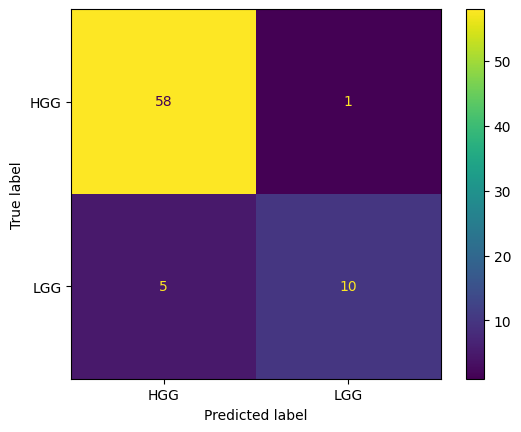

In [25]:
# Test the best model on the held-out test dataset

best_model = random_search.best_estimator_

test_inputs_df = test_data.drop("Group")
test_targets_df = test_data.select("Group")
X_test = preprocessor.transform(test_inputs_df)
y_test = label_encoder.transform(test_targets_df.to_numpy().ravel())

y_pred = best_model.predict(X_test)
print("Balanced Accuracy on test data:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_encoder.classes_
)